In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
try:
    reload(galpy.df_src.streampepperdf)
    reload(galpy.df_src.streampepperdf.galpy.df_src.streamgapdf)
    reload(galpy.df_src.streampepperdf.galpy.df_src.streamdf)
except NameError:
    import galpy.df_src.streampepperdf
import numpy
from scipy import signal, ndimage
import statsmodels.api as sm
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_conversion, bovy_coords
from galpy.util import bovy_plot
%pylab inline
import seaborn as sns
R0, V0= 8., 220.

Populating the interactive namespace from numpy and matplotlib


# Computing stream peppering with *galpy*

We again work with the stream model from Sanders, Bovy, & Erkal (2015) as a baseline. We compute the combined effect of two impacts at the same time, but 1 radian in parallel angle apart (one is $10^8\,M_\odot$, the other $10^7\,M_\odot$). The probability $p(\Omega_\parallel,\theta_\parallel)$ and the mean are given by:

In [3]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
sigv= 0.365*(10./2.)**(1./3.)
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]])
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),10001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1]),prog_init.y(times[-1]),prog_init.z(times[-1]),
              prog_init.vx(times[-1]),prog_init.vy(times[-1]),prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5]])
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)

In [4]:
sdf_pepper= galpy.df_src.streampepperdf.streampepperdf(\
    sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
    leading=False,nTrackChunks=26,nTrackIterations=1,
    sigMeanOffset=4.5,
    tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
    Vnorm=V0,Rnorm=R0,
    impactb=[0.,0.],
    subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                            [6.82200571,132.7700529,149.4174464]])/V0, # from Denis' email
    timpact=[2.88/bovy_conversion.time_in_Gyr(V0,R0),2.88/bovy_conversion.time_in_Gyr(V0,R0)],
    impact_angle=[-1.34,-0.34],
    GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)],
    rs=[0.625/R0,0.625/R0],spline_order=1) 

In [5]:
xs= numpy.linspace(0.,4.5,101)
mO= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
mO_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).meanOmega(x,oned=True) for x in xs])
# Compare to random sample
numpy.random.seed(1)
aa_mock_per= sdf_pepper.sample(n=10000,returnaAdt=True)
Opar= numpy.dot(aa_mock_per[0].T-sdf_pepper._progenitor_Omega,sdf_pepper._dsigomeanProgDirection)
apar= numpy.dot(aa_mock_per[1].T-sdf_pepper._progenitor_angle,sdf_pepper._dsigomeanProgDirection)

/Users/bovy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



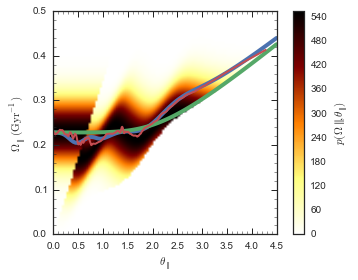

In [6]:
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,4.5,101)
y= numpy.array([sdf_pepper.pOparapar(Opars,a) for a in apars])
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(xs,mO*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
lowess = sm.nonparametric.lowess
z = lowess(Opar,apar,frac=0.03)
plot(z[:,0],z[:,1]*bovy_conversion.freq_in_Gyr(V0,R0),lw=2.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

The density along the stream is

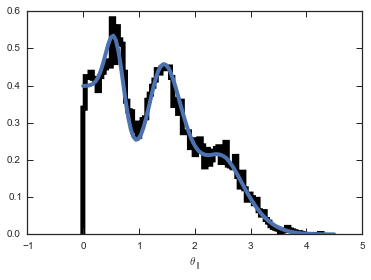

In [7]:
xs= numpy.linspace(0.,4.5,101)
# Compute
dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
dum= hist(apar,bins=101,normed=True,histtype='step',color='k',zorder=0,lw=5.)
xlabel(r'$\theta_\parallel$')

Let's try the same for two $10^5\,M_\odot$ impacts. Can we get the frequency deviation accurately with this code? The frequency deviation is

In [8]:
sdf_pepper.set_impacts(impact_angle=[-1.34,-0.34],impactb=[0.,0.],
                       subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                               [6.82200571,132.7700529,149.4174464]])/V0,
                       timpact=[2.88/bovy_conversion.time_in_Gyr(V0,R0),
                                2.88/bovy_conversion.time_in_Gyr(V0,R0)],
                       GM=[10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                           10.**-5./bovy_conversion.mass_in_1010msol(V0,R0)],
                       rs=[0.04/R0,0.04/R0])

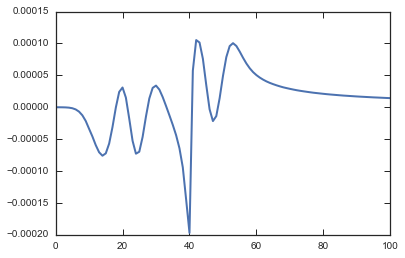

In [9]:
xs= numpy.linspace(0.,4.5,101)
mO= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
mO_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).meanOmega(x,oned=True) for x in xs])
plot((mO-mO_unp)*bovy_conversion.freq_in_Gyr(V0,R0),lw=2.)

and the relative density

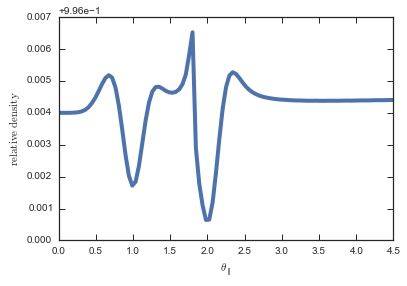

In [10]:
dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
dens_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper)._density_par(x) for x in xs])
plot(xs,(dens/numpy.sum(dens))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\mathrm{relative\ density}$')

This works very well.

## Some simulated sets of impacts

In [11]:
def rs(GM):
    """Give scale radius for a given mass"""
    return (GM/10.**-3.*bovy_conversion.mass_in_1010msol(V0,R0))**0.4*0.25/R0
def N(M):
    return 10.*(10.**7./M)

Let's look at $10^7\,M_\odot$ first, assuming about 10 impacts:

In [12]:
# Simulate
sdf_pepper.simulate(rate=10.,
                    sample_GM=lambda: 10.**-3./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)

In [13]:
sdf_pepper._draw_impact_velocities(sdf_pepper._uniq_timpact[0],120./220.,0.1,n=1)

array([[ 0.59942063, -0.21369076,  0.37456869]])

The mean parallel frequency as a function of angle is

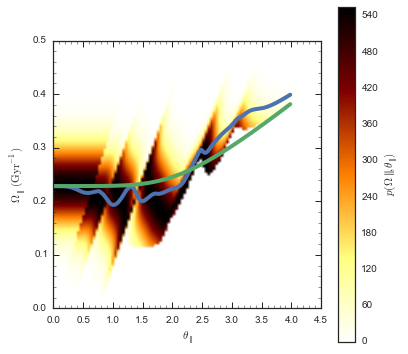

In [14]:
xs= numpy.arange(0.,4.,0.02)
mO= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
mO_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).meanOmega(x,oned=True) for x in xs])
dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
dens_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper)._density_par(x) for x in xs])
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,4.5,101)
y= numpy.array([sdf_pepper.pOparapar(Opars,a) for a in apars])
figsize(6,6)
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(xs,mO*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

and the density and density contrast is

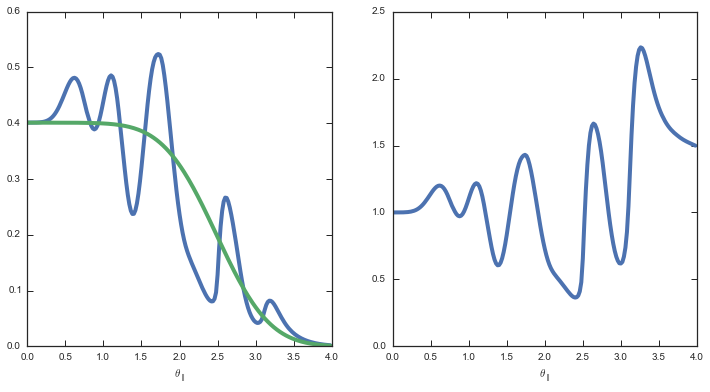

In [15]:
figsize(12,6)
subplot(1,2,1)
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp/numpy.sum(dens_unp)/(xs[1]-xs[0]),lw=4.)
xlabel(r'$\theta_\parallel$')
subplot(1,2,2)
plot(xs,(dens/numpy.sum(dens))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')

Now let's look at $10^6\,M_\odot$, assuming about 30 impacts. The mean parallel frequency becomes

In [16]:
# Simulate
sdf_pepper.simulate(rate=30.,
                    sample_GM=lambda: 10.**-4./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)

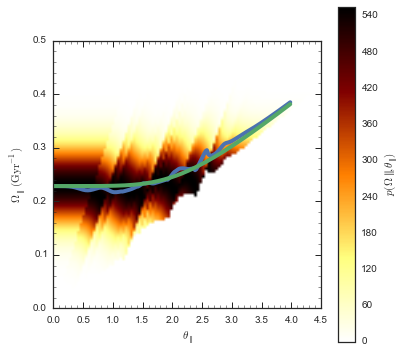

In [17]:
mO_1e6= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
dens_1e6= numpy.array([sdf_pepper.density_par(x) for x in xs])
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,4.5,101)
y= numpy.array([sdf_pepper.pOparapar(Opars,a) for a in apars])
figsize(6,6)
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(xs,mO_1e6*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

and the density and density contrast are

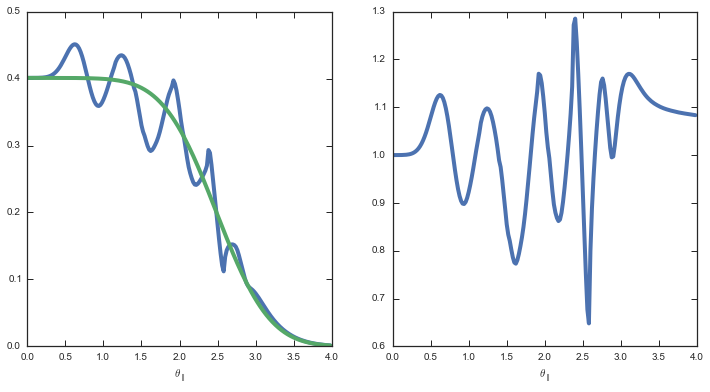

In [18]:
figsize(12,6)
subplot(1,2,1)
plot(xs,dens_1e6/numpy.sum(dens_1e6)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp/numpy.sum(dens_unp)/(xs[1]-xs[0]),lw=4.)
xlabel(r'$\theta_\parallel$')
subplot(1,2,2)
plot(xs,(dens_1e6/numpy.sum(dens_1e6))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')

In [19]:
# Simulate
sdf_pepper.simulate(rate=100.,
                    sample_GM=lambda: 10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)

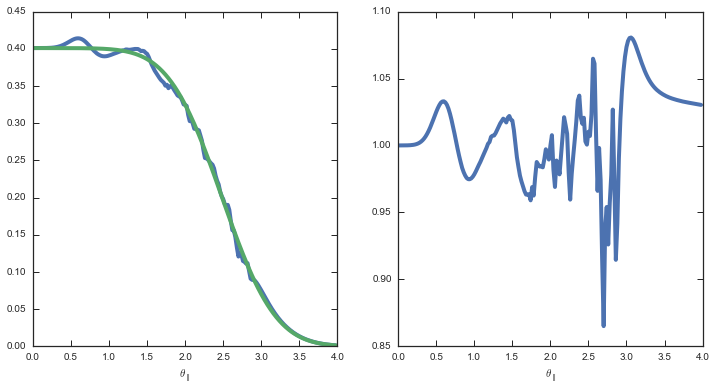

In [20]:
dens_1e5= numpy.array([sdf_pepper.density_par(x) for x in xs])
figsize(12,6)
subplot(1,2,1)
plot(xs,dens_1e5/numpy.sum(dens_1e5)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp/numpy.sum(dens_unp)/(xs[1]-xs[0]),lw=4.)
xlabel(r'$\theta_\parallel$')
subplot(1,2,2)
plot(xs,(dens_1e5/numpy.sum(dens_1e5))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')

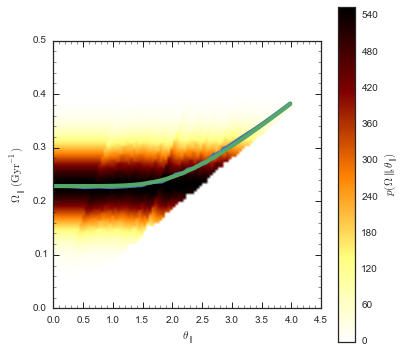

In [21]:
mO_1e5= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
dens_1e5= numpy.array([sdf_pepper.density_par(x) for x in xs])
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,4.5,101)
y= numpy.array([sdf_pepper.pOparapar(Opars,a) for a in apars])
figsize(6,6)
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(xs,mO_1e5*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

The power spectrum of the parallel frequency and density differences are given on the diagonal of the following set of plots; the cross power-spectrum is the off-diagonal plot:

/Users/bovy/anaconda/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 124, using nperseg = 124
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))



(1e-05, 0.2)

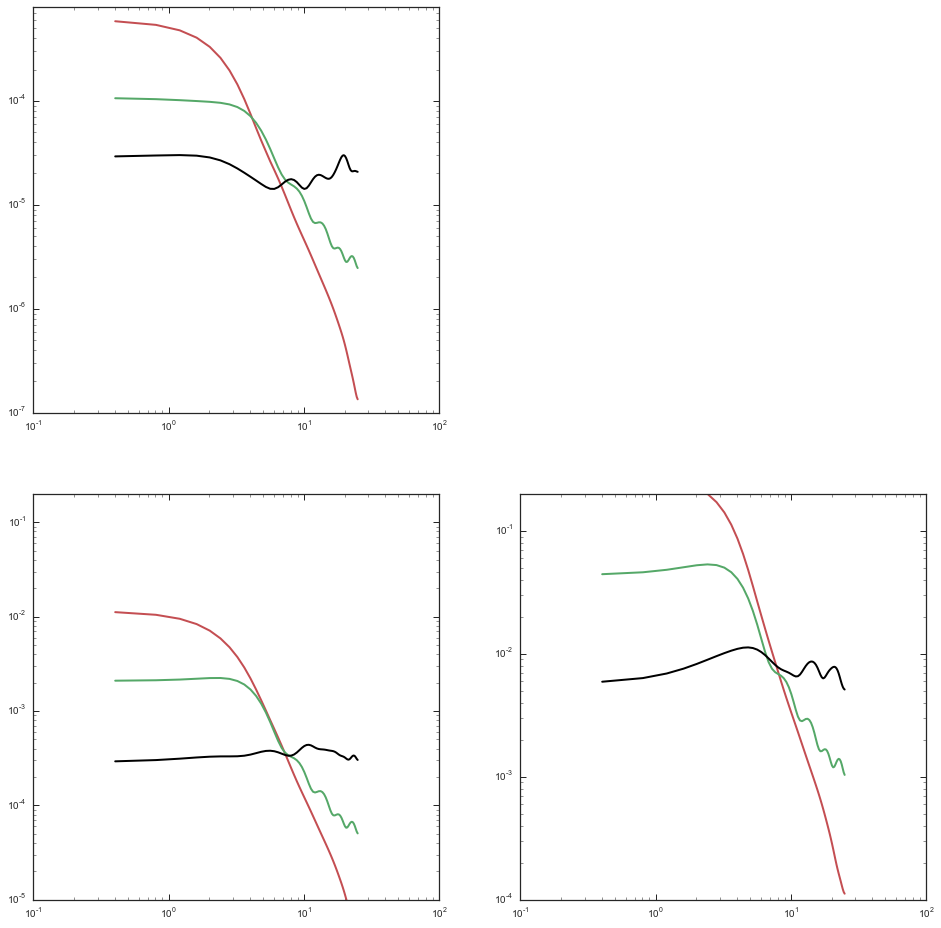

In [22]:
indx= xs > 1.5 # because we put a bunch at angle=0.1=0.7 now (see dip above)
smooth_len= 3
figsize(16,12)
figsize(16,16)
plotkwargs= {'alpha':1.,'lw':2.}
ppy= signal.welch((mO-mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')
px= ppy[0]
ppy= ndimage.filters.gaussian_filter1d(ppy[1],smooth_len)
subplot(2,2,1)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((mO_1e6-mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(
    signal.welch(numpy.random.normal(size=numpy.sum(indx))*0.0001/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color='k',**plotkwargs)
ylim(0.0000001,0.0008)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
subplot(2,2,4)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens_1e6[indx]/numpy.sum(dens_1e6[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(
    signal.welch(numpy.random.normal(size=numpy.sum(indx))*0.05,
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color='k',**plotkwargs)
ylim(0.0001,0.2)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                (mO-mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
subplot(2,2,3)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens_1e6[indx]/numpy.sum(dens_1e6[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                (mO_1e6-mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd(numpy.random.normal(size=numpy.sum(indx))*0.05,
                numpy.random.normal(size=numpy.sum(indx))*0.0001/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
loglog(px,numpy.sqrt(ppy),color='k',**plotkwargs)
ylim(0.00001,0.2)

Taking the power spectra directly without subtracting the smooth stream gives the following. The large scales are now dominated by the smooth-stream structure (also directly computed as the blue line):

(1e-06, 0.02)

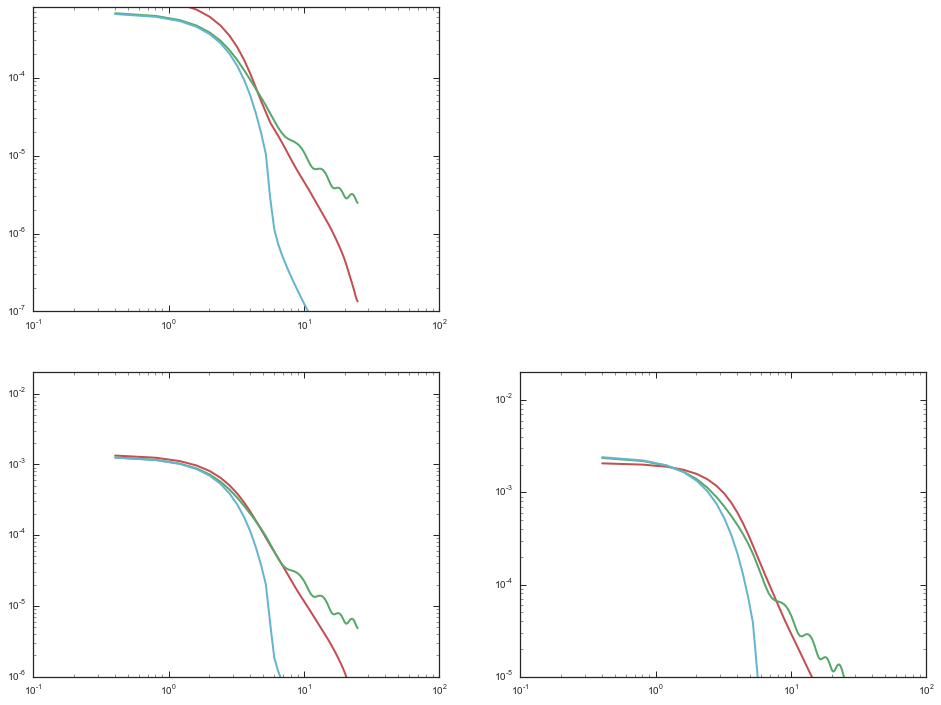

In [23]:
indx= xs > 1.5 # because we put a bunch at angle=0.1=0.7 now (see dip above)
smooth_len= 3
figsize(16,12)
plotkwargs= {'alpha':1.,'lw':2.}
ppy= signal.welch((mO)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')
px= ppy[0]
ppy= ndimage.filters.gaussian_filter1d(ppy[1],smooth_len)
subplot(2,2,1)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((mO_1e6)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[5],**plotkwargs)
ylim(0.0000001,0.0008)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
subplot(2,2,4)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens_1e6[indx]/numpy.sum(dens_1e6[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[5],**plotkwargs)

ylim(0.00001,0.02)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens[indx]/numpy.sum(dens[indx])),
                (mO)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
subplot(2,2,3)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens_1e6[indx]/numpy.sum(dens_1e6[indx])),
                (mO_1e6)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens_unp[indx]/numpy.sum(dens_unp[indx])),
                (mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[5],**plotkwargs)
ylim(0.000001,0.02)

Median power spectra of 4 different masses like in bell.ipynb before. Conservative:

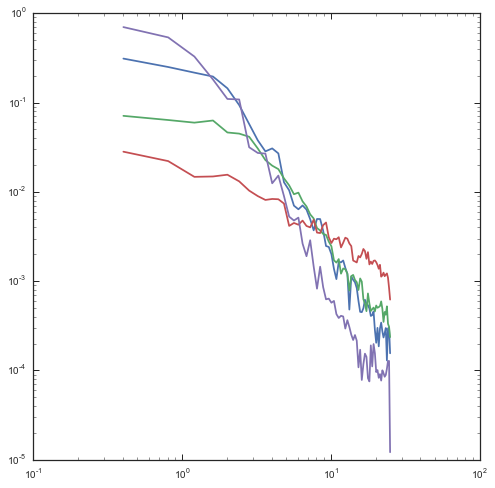

In [24]:
figsize(8,8)
smooth_len= 0
ntrials= 21
ppy= numpy.zeros((len(px),ntrials))
for ii in range(ppy.shape[1]):
    # Simulate
    sdf_pepper.simulate(rate=10.,sample_GM=lambda: 10.**-3./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)
    dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
    ppy[:,ii]= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
ppy= numpy.zeros((len(px),ntrials))
for ii in range(ppy.shape[1]):
    # Simulate
    sdf_pepper.simulate(rate=30.,sample_GM=lambda: 10.**-4./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)
    dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
    ppy[:,ii]= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
ppy= numpy.zeros((len(px),ntrials))
for ii in range(ppy.shape[1]):
    # Simulate
    sdf_pepper.simulate(rate=100.,sample_GM=lambda: 10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)
    dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
    ppy[:,ii]= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
# Bit of a hack
ppy= numpy.zeros((len(px),ntrials))
for ii in range(ppy.shape[1]):
    # Simulate
    sdf_pepper.simulate(rate=3.,sample_GM=lambda: 10.**-2.2/bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)
    dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
    ppy[:,ii]= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))

Less conservative...

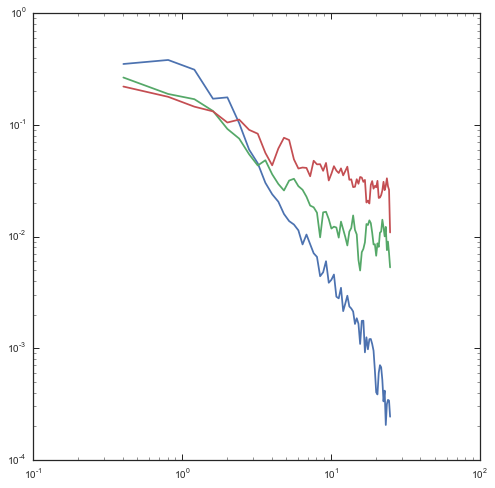

In [25]:
figsize(8,8)
smooth_len= 0
ntrials= 21
ppy= numpy.zeros((len(px),ntrials))
for ii in range(ppy.shape[1]):
    # Simulate
    sdf_pepper.simulate(rate=10.,sample_GM=lambda: 10.**-3./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)
    dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
    ppy[:,ii]= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
ppy= numpy.zeros((len(px),ntrials))
for ii in range(ppy.shape[1]):
    # Simulate
    sdf_pepper.simulate(rate=100.,sample_GM=lambda: 10.**-4./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)
    dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
    ppy[:,ii]= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
ppy= numpy.zeros((len(px),ntrials))
for ii in range(ppy.shape[1]):
    # Simulate
    sdf_pepper.simulate(rate=1000.,sample_GM=lambda: 10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)
    dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
    ppy[:,ii]= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
#ppy= numpy.zeros((len(px),ntrials))
#for ii in range(ppy.shape[1]):
#    # Simulate
#    sdf_pepper.simulate(rate=1.,sample_GM=lambda: 10.**-2.2/bovy_conversion.mass_in_1010msol(V0,R0),
#                    sample_rs=rs)
#    dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
#    ppy[:,ii]= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
#                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
#loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))

In [26]:
print aAI.actionsFreqs(RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2]+1./V0,
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5])[5]-aAI.actionsFreqs(RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5])[5]


[-0.00122949]


## Wavelet analysis

Horsing around with wavelets and power-spectra based on them...

In [27]:
import wavelets #from https://github.com/aaren/wavelets
wavelet= wavelets.Morlet()

In [28]:
class w1Wavelet(object):
    def __init__(self):
        return None

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self,t,s=1.0):
        """
        w2 wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        real: value of the w2 wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        """
        x= t/s
        output= (x**6.-1.)*numpy.exp(-1.2321*x**2.)#(x**8.-1.)*numpy.exp(-0.559*x**4.)
        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent fourier period of morlet"""
        return 4 * np.pi * s 
    
    # Frequency representation
    def frequency(self,w,s=1.0):
        """Frequency representation of morlet.
        s - scale
        w - angular frequency
        """
        raise NotImplementedError('frequency not implemented for this wavelet')

    def coi(self,s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        raise NotImplementedError('coi not implemented for this wavelet')
wavelet= w1Wavelet()
wavelet= wavelets.Morlet()

(0.001, 300)

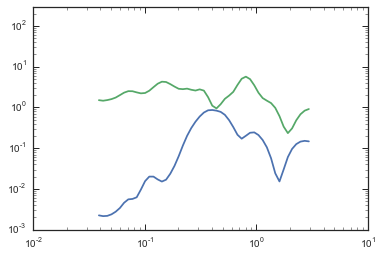

In [29]:
figsize(6,4)
indx= xs > 1. # because we put a bunch at angle=0.1=0.7 now (see dip above)
sig_dens1e6= (dens_1e6[indx]/numpy.sum(dens_1e6[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx]))
wa_dens1e6= wavelets.WaveletAnalysis(sig_dens1e6,dt=1.,wavelet=wavelet,unbias=True)
wf_dens1e6= wa_dens1e6.wavelet_transform
scales_dens1e6= wa_dens1e6.scales*(xs[1]-xs[0])
power_dens1e6= wa_dens1e6.wavelet_power
loglog(scales_dens1e6,numpy.sum(power_dens1e6[:,10:],axis=1))
sig_dens= (dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx]))
wa_dens= wavelets.WaveletAnalysis(sig_dens,dt=1.,wavelet=wavelet,unbias=True)
wf_dens= wa_dens.wavelet_transform
scales_dens= wa_dens.scales*(xs[1]-xs[0])
power_dens= wa_dens.wavelet_power
loglog(scales_dens,numpy.sum(power_dens[:,10:],axis=1))
xlim(0.01,10)
ylim(10.**-3.,300)

(1e-05, 3)

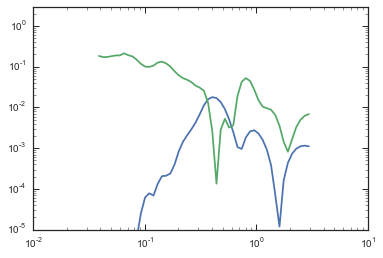

In [30]:
figsize(6,4)
indx= xs > 1. # because we put a bunch at angle=0.1=0.7 now (see dip above)
sig_dens1e6= (dens_1e6[indx]/numpy.sum(dens_1e6[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx]))
wa_dens1e6= wavelets.WaveletAnalysis(sig_dens1e6,dt=1.,wavelet=wavelet,unbias=True)
wf_dens1e6= wa_dens1e6.wavelet_transform
scales_dens1e6= wa_dens1e6.scales*(xs[1]-xs[0])
power_dens1e6= wa_dens1e6.wavelet_power
loglog(scales_dens1e6,power_dens1e6[:,60])
sig_dens= (dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx]))
wa_dens= wavelets.WaveletAnalysis(sig_dens,dt=1.,wavelet=wavelet,unbias=True)
wf_dens= wa_dens.wavelet_transform
scales_dens= wa_dens.scales*(xs[1]-xs[0])
power_dens= wa_dens.wavelet_power
loglog(scales_dens,power_dens[:,60])
xlim(0.01,10)
ylim(10.**-5.,3)

/Users/bovy/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

/Users/bovy/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):

/Users/bovy/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1166: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))

/Users/bovy/anaconda/lib/python2.7/site-packages/matplotlib/image.py:359: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")



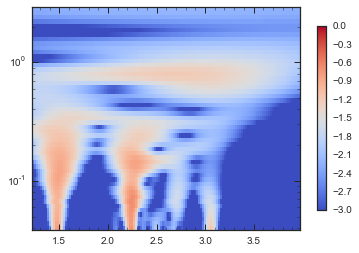

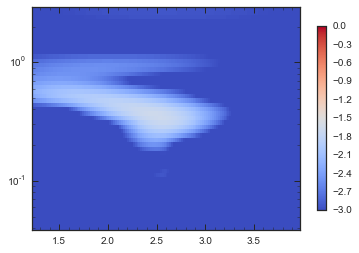

In [31]:
bovy_plot.bovy_dens2d(numpy.log10(power_dens[:,10:]),origin='lower',colorbar=True,cmap='coolwarm',
                      interpolation='nearest',xrange=[xs[indx][10],xs[indx][-1]],
                      yrange=[scales_dens[0],scales_dens[-1]],
                     vmin=-3.,vmax=0.)
ax= plt.gca()
ax.set_yscale('log')
bovy_plot.bovy_dens2d(numpy.log10(power_dens1e6[:,10:]),origin='lower',colorbar=True,cmap='coolwarm',
                      interpolation='nearest',xrange=[xs[indx][10],xs[indx][-1]],
                      yrange=[scales_dens1e6[0],scales_dens1e6[-1]],
                     vmin=-3.,vmax=0.)
ax= plt.gca()
ax.set_yscale('log')

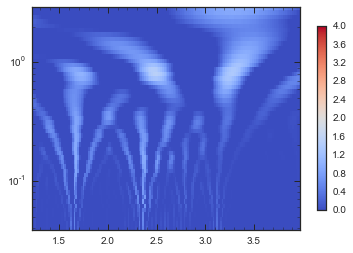

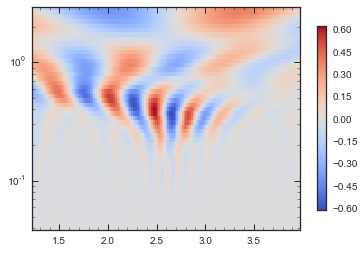

In [32]:
bovy_plot.bovy_dens2d(wa_dens.wavelet_transform.real,origin='lower',colorbar=True,cmap='coolwarm',
                      interpolation='nearest',xrange=[xs[indx][10],xs[indx][-1]],
                      yrange=[scales_dens[0],scales_dens[-1]],
                     vmin=0.,vmax=4.)
ax= plt.gca()
ax.set_yscale('log')
bovy_plot.bovy_dens2d(wa_dens1e6.wavelet_transform.real,origin='lower',colorbar=True,cmap='coolwarm',
                      interpolation='nearest',xrange=[xs[indx][10],xs[indx][-1]],
                      yrange=[scales_dens[0],scales_dens[-1]])
ax= plt.gca()
ax.set_yscale('log')

In [33]:
power_dens.shape

(51, 149)

In [34]:
p= numpy.fft.fft((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])))

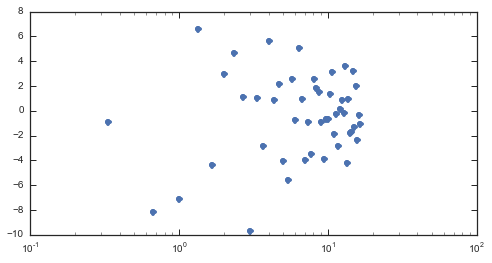

In [35]:
figsize(8,4)
p= numpy.fft.fft((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])))
semilogx(numpy.fft.fftfreq(numpy.sum(indx),d=xs[1]-xs[0])[1:50],p.real[1:50],'o')

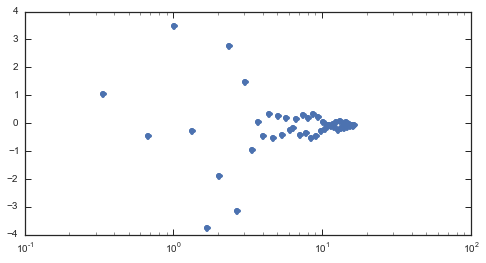

In [36]:
figsize(8,4)
p= numpy.fft.fft((dens_1e6[indx]/numpy.sum(dens_1e6[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])))
semilogx(numpy.fft.fftfreq(numpy.sum(indx),d=xs[1]-xs[0])[1:50],p.real[1:50],'o')